# Quantizing a neural network using the *additive noise annealing* algorithm

In this notebook we will introduce the `quantlib` tools that enable the structural transformations inherent to the training and deployment of a *quantized neural network* (QNN):

* floating-point to fake-quantized (*float2fake*);
* fake-quantized to true-quantized (*fake2true*).

In this notebook we will not discuss the training process itself.


## Post-training quantization algorithms vs. quantization-aware training algorithms

Quantization algorithms for deep neural networks come in two flavours:

* *post-training quantization* algorithms: these algorithms take in input trained floating-point networks and output quantized counterparts that use quantized operands;
* *quantization-aware training algorithms: at training time, these algorithms map quantized values into floating-point numeric ranges to ease learning; after training, specific arithmetic conversions allow to transform the trained floating-point program into a quantized program.

Post-training quantization algorithms are desirable for several reasons, the most important ones being data privacy and ease of application.
The main drawback of post-training quantization algorithms are that they do not work well when involving "aggressive" quantization schemes (i.e., quantization schemes using less than four bits per operand): in such cases, the statistical accuracy of the quantized networks drop significantly with respect to that of the original floating-point programs.

For this reason, when targetting extremely resource-constrained computers that benefit from using specialised accelerators, quantization-aware training algorithms are the preferred choice.

In this notebook we will focus on a quantization-aware training algorithm called *additive noise annealing* (ANA).


## The structure of the `quantlib` package

The `quantlib.algorithms` package consists of several sub-packages providing the building blocks to build DNNs that can be trained using state-of-the-art quantization-aware training algorithms.

Of course, the user can manually define new PyTorch networks using such building blocks.
Sometimes, though, before implementing a brand-new DNN topology by hand it might be worth it to try and quantize an existing floating-point topology that has shown good performance at the target task.
In this case, the network's PyTorch definition might already be available, and it is preferable to replace its floating-point operations with counterparts that support quantization in an automated way, without the hazards inherent to manual rewriting.
The facilities to perform such *float2fake* conversions are implemented in the `quantlib.editing.lightweight` sub-package.

After training, a fake-quantized network is in general not yet ready to be executed on energy-efficient hardware.
This limitation is due to several reasons.
Some examples:

* the quantized operands (weights, features, or both) are "immersed" in some floating-point range, a numeric representation that nullifies the benefits of quantization;
* batch normalisation operations, where the channel means, standard deviations, weights and biases are represented by floating-point numbers, are still executed.

Enabling execution on energy-efficient hardware requires the user to transform the program in such a way that these operations are removed, while at the same time preserving the functional mapping performed.
This *fake2true* conversion process usually necessitates a complete overview of the low-level operations that are executed under the hood by a PyTorch fake-quantized networks, including their connectivity and the data format (type and precision) of their operands.
Since PyTorch build computational graphs dynamically, deriving information about the connectivity requires *tracing* a fake-quantized graph.
After this step, *graph rewriting* and *arithmetic conversion* will be involved.
The facilities to perform these actions are implemented in the `quantlib.editing.graphs` sub-package.

Since QNNs are often going to target hardware accelerators with specific ISAs, the agent performing a *fake2true* conversion must be aware of the properties of the underlying platform, which in `quantlib` jargon we refer to as a `backend`.
For this reason, some of the abstractions defined in `quantlib.editing.graphs` are sub-classed by entities defined in modules belonging to sub-packages of the `quantlib.backends` package.

To summarise:

* *float2fake* conversions take as inputs floating-point PyTorch DNNs and use the facilities defined in the `quantlib.editing.lighweight` package to return fake-quantized QNNs;
* *fake2true* conversions take as inputs fake-quantized QNNs and use the facilities defined in the `quantlib.editing.graphs` and (some of) the facilities defined in the `quantlib.backends` package to return a software "golden model" of the program that will actually run on the target device.


## Quantizing a VGG8 on CIFAR-10 with ANA targetting CUTIE

As a guiding example, we will go through the process of quantizing a simple feedforward *convolutional neural network* (CNN) topology (VGG8) to process CIFAR-10 RGB images.


In [1]:
import torch
import torch.nn as nn


_CONFIGS = {
    'VGG8': ['M', 256, 256, 'M', 512, 512, 'M'],
    'VGG9': [128, 'M', 256, 256, 'M', 512, 512, 'M'],
    'VGG11': [128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M'],
}


class VGG(nn.Module):

    def __init__(self, config: str, capacity: int = 1, use_bn_features: bool = False, use_bn_classifier: bool = False, num_classes: int = 10, seed: int = -1) -> None:

        super(VGG, self).__init__()

        self.pilot      = self._make_pilot(capacity, use_bn_features)
        self.features   = self._make_features(config, capacity, use_bn_features)
        self.avgpool    = nn.AdaptiveAvgPool2d((4, 4))
        self.classifier = self._make_classifier(capacity, use_bn_classifier, num_classes)

        self._initialize_weights(seed=seed)

    @staticmethod
    def _make_pilot(capacity: int, use_bn_features: bool) -> nn.Sequential:

        modules = []
        modules += [nn.Conv2d(3, 128 * capacity, kernel_size=3, padding=1, bias=not use_bn_features)]
        modules += [nn.BatchNorm2d(128 * capacity)] if use_bn_features else []
        modules += [nn.ReLU(inplace=True)]

        return nn.Sequential(*modules)

    @staticmethod
    def _make_features(config: str, capacity: int, use_bn_features: bool) -> nn.Sequential:

        modules = []
        in_channels = 128 * capacity
        for v in _CONFIGS[config]:
            if v == 'M':
                modules += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                out_channels = v * capacity
                modules += [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=not use_bn_features)]
                modules += [nn.BatchNorm2d(out_channels)] if use_bn_features else []
                modules += [nn.ReLU(inplace=True)]
                in_channels = out_channels

        return nn.Sequential(*modules)

    @staticmethod
    def _make_classifier(capacity: int, use_bn_classifier: bool, num_classes: int) -> nn.Sequential:

        modules = []
        modules += [nn.Linear(512 * capacity * 4 * 4, 1024, bias=not use_bn_classifier)]
        modules += [nn.BatchNorm1d(1024)] if use_bn_classifier else []
        modules += [nn.ReLU(inplace=True)]
        modules += [] if use_bn_classifier else [nn.Dropout()]
        modules += [nn.Linear(1024, 1024, bias=not use_bn_classifier)]
        modules += [nn.BatchNorm1d(1024)] if use_bn_classifier else []
        modules += [nn.ReLU(inplace=True)]
        modules += [] if use_bn_classifier else [nn.Dropout()]
        modules += [nn.Linear(1024, num_classes)]

        return nn.Sequential(*modules)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.pilot(x)
        x = self.features(x)
        x = self.avgpool(x)

        x = x.view(x.size(0), -1)  # https://stackoverflow.com/questions/57234095/what-is-the-difference-of-flatten-and-view-1-in-pytorch

        x = self.classifier(x)

        return x

    def _initialize_weights(self, seed: int):

        if seed >= 0:
            torch.manual_seed(seed)

        for m in self.modules():

            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


In [2]:
net = VGG('VGG8', use_bn_features=True, use_bn_classifier=True)

We aim at quantizing both its weights and features to ternary values (*ternary neural network*, TNN), and at deriving a software golden model for a program running on the *completely unrolled ternary inference engine* (CUTIE) TNN accelerator.

The chosen quantization-aware training algorithm is the *additive noise annealing* (ANA) algorithm.
Loosely speaking, this algorithm replaces non-differentiable quantizers with almost-everywhere differentiable counterparts obtained by applying the expectation operator to quantizers that take noisy inputs.
As the training algorithm progresses, the noise distribution is collapsed to a Dirac's delta, resulting in the differentiable function being "frozen" into the non-differentiable quantizer.


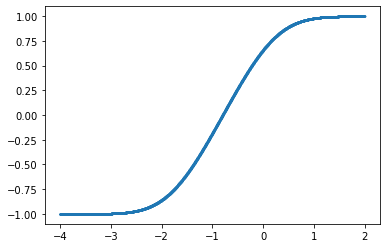

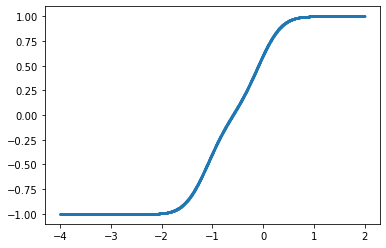

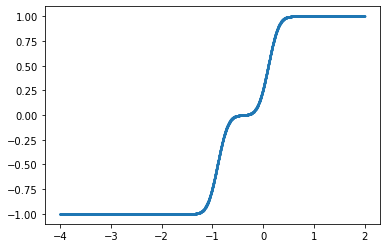

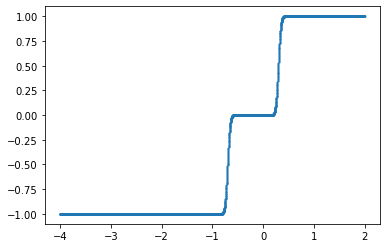

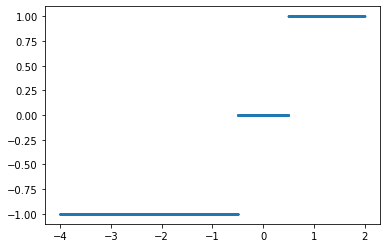

In [3]:
import matplotlib.pyplot as plt

import quantlib.algorithms as qa


act = qa.ana.ANAActivation({'nbits': 2, 'signed': True, 'balanced': True, 'eps': 1.0}, 'normal')

x = torch.arange(-4.0, 2.0, step=0.001).to(dtype=torch.float32)
x.requires_grad = False

for lambda_ in torch.arange(0.8, -0.1, step=-0.2):

    act.set_fnoise(-lambda_, (-lambda_) ** 2)
    y = act(x)

    plt.scatter(x, y, s=1)
    plt.show()


## Converting a floating-point graph into a fake-quantized graph

As described in the introduction, the `quantlib.editing.lightweight` sub-package provides the functionality to perform tree traversal and leaf replacement.
In this section we will illustrate the main abstractions implemented in the package and how the user can use them to transform a floating-point PyTorch network into a fake-quantized one.

We start by importing the corresponding namespace.


In [4]:
import quantlib.editing.lightweight as qlw

### DNNs in PyTorch

In PyTorch, users can define DNNs as sub-classes of `torch.nn.Module`.
We can distinguish between two main flavours of PyTorch modules:

* *basic* modules;
* *container* modules.

Basic modules represent primitive transformations.
Essentially, they are Python wrappers for operations that support automatic differentiation, hence enabling the execution of the back-propagation algorithm.
Each basic module is characterised by a *type*

Container modules are, well, containers for other PyTorch modules.
The purpose of container modules is structuring the execution of their children modules.
For instance, the purpose of a `torch.nn.Sequential` module is creating a composable pipeline of transformations that should be executed one after the other.
The definition of a container module is recursive, in that the modules that it contains can be either container themselves or basic modules.
In PyTorch, DNN objects are almost always containers.

Due to the recursive nature of PyTorch modules, a PyTorch network object can be represented as a **tree** data structure.
The root and intermediate nodes of such a tree are container modules, whereas its leaves are basic modules.
Moreover, an alphanumeric string is attached to each node, allowing to refer them by *name*.


### `LightweightGraph`

Despite its name, a `LightweightGraph` is a wrapper structure around a `torch.nn.Module` object that provides a key functionality: the `rebuild_nodes_list` method traverses the tree of `torch.nn.Module`s and returns a list of `LightweightNode`.
Each `LightweightNode` is a pair composed by:

* a string concatenating the names of each traversed node, separated by dots;
* a reference to a non-container `torch.nn.Module`.

The list of `LightweightNode` (a private attribute denoted by `_nodes_list`) can be inspected using the method `show_nodes_list`.
Instead of printing the reference to the `torch.nn.Module` component, its type will be printed instead; this design decision is important since in the context of of *float2fake* conversion we aim at replacing `torch.nn.Module` of specific types with fake-quantized counterparts.


In [5]:
lwg = qlw.LightweightGraph(net)
lwg.show_nodes_list()


pilot.0                        <class 'torch.nn.modules.conv.Conv2d'>
pilot.1                        <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
pilot.2                        <class 'torch.nn.modules.activation.ReLU'>
features.0                     <class 'torch.nn.modules.pooling.MaxPool2d'>
features.1                     <class 'torch.nn.modules.conv.Conv2d'>
features.2                     <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
features.3                     <class 'torch.nn.modules.activation.ReLU'>
features.4                     <class 'torch.nn.modules.conv.Conv2d'>
features.5                     <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
features.6                     <class 'torch.nn.modules.activation.ReLU'>
features.7                     <class 'torch.nn.modules.pooling.MaxPool2d'>
features.8                     <class 'torch.nn.modules.conv.Conv2d'>
features.9                     <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
features.10               

### `Filter`s and  `LightweightRule`s

In the scope of *float2fake* conversion, it is important that we are able to replace leaf nodes selectively.
Such replacements act in two steps:

* identifying the *application points*, i.e., the `LightweightNode`s that satisfy some predefined criteria;
* performing the *replacement action*.

For the purpose of identifying application points, the `qlw.rules.filters` module implements `Filter` objects that can be applied to lists of `LightweightNode`s.

There are two types of *basic* filters:

* `NameFilter`s, that filter the input list by matching a regular expression against the first component of each item in the list;
* `TypeFilter`s, that filter the input list using the type of the second component as a reference.

*Composed* `Filter`s can be built using logical operators:

* `-` negation (unary);
* `&` conjunction (either binary or variadic);
* `|` disjunction (either binary or variadic).

For example, to identify all the `torch.nn.Conv2d` PyTorch modules in the feature extractor part of the VGG network implemented above, we can define the following filters:


In [6]:
# basic type-based filters
filter_conv2d = qlw.rules.filters.TypeFilter(nn.Conv2d)
filter_linear = qlw.rules.filters.TypeFilter(nn.Linear)
filter_relu   = qlw.rules.filters.TypeFilter(nn.ReLU)

# basic name-based filters
filter_pilot      = qlw.rules.filters.NameFilter('pilot')
filter_features   = qlw.rules.filters.NameFilter('features')
filter_classifier = qlw.rules.filters.NameFilter('classifier')

# composed filter example
filter_conv2d_pilot_or_features = filter_conv2d & (filter_pilot | filter_features)


In [7]:
for n in filter_conv2d_pilot_or_features(lwg.nodes_list):
    print("{:20s} {}".format(n.name, n.module.__class__))
    

features.11          <class 'torch.nn.modules.conv.Conv2d'>
features.4           <class 'torch.nn.modules.conv.Conv2d'>
features.8           <class 'torch.nn.modules.conv.Conv2d'>
features.1           <class 'torch.nn.modules.conv.Conv2d'>
pilot.0              <class 'torch.nn.modules.conv.Conv2d'>


Once a `Filter` has been defined, it must be coupled with a suitable replacement function that can implement the desired leaf replacement.
For example, we would like to replace `torch.nn.Conv2d` PyTorch modules with `quantlib.algorithms.ana.ANAConv2d` counterparts.
This functionality is performed by `LightweightRule`s.

Whereas `TypeFilter`s can be applied to generic PyTorch networks, we can not make the same assumption for `NameFilter`s since module names depend on the definition of the class of the specific network that is the subject of the *float2fake* conversion.
Thus, to ensure generality we assume that `Filter`s are specific to the network object.

On the contrary, the quality of the replacement depends just on the type of the `torch.nn.Module`s returned by the application of a `Filter` and of the fake-quantized modules that are goint to replace it.
This network-independent part of a `LightweightRule` is implemented by the so-called `replacement_fun` attribute of the rule.
A replacement function takes as input a leaf PyTorch module (i.e., a non-container PyTorch module) and returns either a container PyTorch module containing basic fake-quantized PyTorch modules or a basic fake-quantized PyTorch module, as defined by the programmer.
Since most quantization-aware training algorithms condition their behaviour on some hyper-parameters, replacement functions can take them as arguments.

A custom `LightweightRule` in then defined according to this procedure:

* the programmer implements the `replacement_fun` in such a way to be agnostic of the networks it will be applied to; the hyper-parameters of the fake-quantized modules are left as arguments; in conjunction with currying, this coding practice can act in a similar way as templatisation in languages such as C++;
* the programmer implements the custom `LightweightRule` by sub-classing the stock `LightweightRule` class; the constructor method of this class should take as inputs actual values for the fake-quantized modules hyper-parameters and use currying (as provided by Python's `functools` package) to instantiate a replacement function from the "template"; also, the constructor method should take a `Filter` as input.

In this way, a user can instantiate a very specific leaf replacement rule by passing the `Filter` that identifies the desired application points in the subject network and the hyper-paremeters for the fake-quantized modules associated with the chosen quantization-aware training algorithm.

The behaviour inherited by the stock `LightweightRule` class is such that applying a custom rule will perform the following actions:

* take as input a `LightweightGraph`s;
* apply the `Filter` to its `nodes_list` and return the target leaves;
* for each target leaf, traverse the tree and replace its module with the one specified by the `replacement_fun`;
* rebuild the `nodes_list` of the `LightweightGraph`: if the wrapped PyTorch module tree is traversed, the target leaves will have been replaced as specified.


In [8]:
from functools import partial

import quantlib.algorithms as qa


# nn.Conv2d -> qa.ana.ANAConv2d
def replace_conv2d_anaconv2d(module:         nn.Module,
                             quantizer_spec: dict,
                             noise_type:     str):
    
    assert isinstance(module, nn.Conv2d)

    return qa.ana.ANAConv2d(in_channels=module.in_channels,
                            out_channels=module.out_channels,
                            kernel_size=module.kernel_size,
                            stride=module.stride,
                            padding=module.padding,
                            dilation=module.dilation,
                            groups=module.groups,
                            bias=module.bias,
                            quantizer_spec=quantizer_spec,
                            noise_type=noise_type)


class ANAConv2dRule(qlw.rules.LightweightRule):
    
    def __init__(self,
                 filter_:        qlw.rules.filters.Filter,
                 quantizer_spec: dict,
                 noise_type:     str):

        replacement_fun = partial(replace_conv2d_anaconv2d, quantizer_spec=quantizer_spec, noise_type=noise_type)
        super(ANAConv2dRule, self).__init__(filter_=filter_, replacement_fun=replacement_fun)


### `LightweightEditor`

Sometimes, graph manipulations can be not trivial to implement.
This usually happens when the subject network is complicated and multiple steps are involved in the *float2fake* conversion.
In these cases, it is more likely to make coding mistakes.
Such mistakes can require the user to re-run the network creation code and the *float2fake* conversion, taking a toll in development time.

Since Python is an interpreted language, we can perform graph manipulations interactively, possibly undoing those transformations that had an effect other than the intended one.
For this purpose, the `quantlib.editing.lighweight` package exposes a `LightweightEditor` abstraction.
The usage is the following:

* at creation, a `LightweightEditor` wraps a `LightweightGraph`;
* the editor protects the wrapped graph from accidental modifications using a lock system called an *editing session*;
* to create the lock, call the `startup` method; note that the lock will be created in open position;
* to pause an editing session, i.e., to close the lock, call the `pause` method;
* to resume an editing session, i.e., to open a previously closed lock, call the `resume` method;
* to conclude an editing session, call the `shutdown` method; this call will destroy the lock; note that this action will delete the history of `LightweightRule` applications, making it impossible to undo the applied modifications.

When in an editing session, the `LightweightEditor` can set up, apply and unapply modifications:

* define the active `LightweightRule` via `set_lwr`; this method takes as argument an object of a class that inherits from `LightweightRule`;
* `apply` the active rule; this action has no effect if no rule has been set;
* `unapply` the most recently applied rule; this action has no effect if there is no rule application in the history of the editor.


In [9]:
lwe = qlw.LightweightEditor(lwg)
lwe.startup()
lwe.pause()


Now, we instantiate the previously defined `LightweightRule` to replace all the `torch.nn.Conv2d` modules in the feature extractor with `quantlib.algorithms.ana.ANAConv2d` modules, and apply it to the `LightweightGraph`.


In [10]:
# replace `nn.Conv2d` PyTorch nodes with `qa.ana.ANAConv2d` quantlib nodes
rho_conv2d = ANAConv2dRule(filter_conv2d_pilot_or_features, {'nbits': 2, 'signed': True, 'balanced': True, 'eps': 1.0}, 'uniform')

lwe.resume()
lwe.set_lwr(rho_conv2d)
lwe.apply()
lwe.pause()

lwe.graph.show_nodes_list()


pilot.0                        <class 'quantlib.algorithms.ana.ana_ops.ANAConv2d'>
pilot.1                        <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
pilot.2                        <class 'torch.nn.modules.activation.ReLU'>
features.0                     <class 'torch.nn.modules.pooling.MaxPool2d'>
features.1                     <class 'quantlib.algorithms.ana.ana_ops.ANAConv2d'>
features.2                     <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
features.3                     <class 'torch.nn.modules.activation.ReLU'>
features.4                     <class 'quantlib.algorithms.ana.ana_ops.ANAConv2d'>
features.5                     <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
features.6                     <class 'torch.nn.modules.activation.ReLU'>
features.7                     <class 'torch.nn.modules.pooling.MaxPool2d'>
features.8                     <class 'quantlib.algorithms.ana.ana_ops.ANAConv2d'>
features.9                     <class 'torch.nn.module

### **Exercise**: define custom `LightweightRule`s

In the following cells, we will define custom `LightweightRule`s to:

* replace all the `torch.nn.Linear` modules in the given list with `quantlib.algorithms.ana.ANALinear` nodes;
* replace all the PyTorch modules implementing non-linear transformations (i.e., `torch.nn.ReLU` nodes) with `quantlib.algorithms.ana.ANAActivation`s.

In particular, your task is defining the functions that will create fake-quantized ANA modules to replace the given  floating-point PyTorch modules.
Remember that the fake-quantized modules should be able to process arrays (i.e., `torch.Tensor`s) with the same shape and with the same data type as those accepted by the floating-point ones.


In [11]:
# nn.Linear -> qa.ana.ANALinear
def replace_linear_analinear(module:         torch.nn.Module,
                             quantizer_spec: dict,
                             noise_type:     str):
    
    assert isinstance(module, torch.nn.Linear)
    
    return qa.ana.ANALinear(in_features=module.in_features,
                            out_features=module.out_features,
                            bias=module.bias,
                            quantizer_spec=quantizer_spec,
                            noise_type=noise_type)


class ANALinearRule(qlw.rules.LightweightRule):
    
    def __init__(self,
                 filter_:        qlw.rules.filters.Filter,
                 quantizer_spec: dict,
                 noise_type:     str):
        
        replacement_fun = partial(replace_linear_analinear, quantizer_spec=quantizer_spec, noise_type=noise_type)
        super(ANALinearRule, self).__init__(filter_=filter_, replacement_fun=replacement_fun)


In [12]:
# nn.ReLU -> qa.ana.ANAActivation
def replace_relu_anaact(module:         torch.nn.Module,
                        quantizer_spec: dict,
                        noise_type:     str):
    
    assert isinstance(module, torch.nn.ReLU)
    return qa.ana.ANAActivation(quantizer_spec=quantizer_spec, noise_type=noise_type)


class ANAActivationRule(qlw.rules.LightweightRule):
    
    def __init__(self,
                 filter_:        qlw.rules.filters.Filter,
                 quantizer_spec: dict,
                 noise_type:     str):
        
        replacement_fun = partial(replace_relu_anaact, quantizer_spec=quantizer_spec, noise_type=noise_type)
        super(ANAActivationRule, self).__init__(filter_=filter_, replacement_fun=replacement_fun)


### **Exercise**: apply custom `LightweightRule`s

In the following cells, we are going to apply the rules that we have just defined to complete the *float2fake* conversion of the VGG8 network.

In particular, your task is defining the `Filter`s that will select:

* all the `torch.nn.Linear` modules but the last one (leaving the last layer of a QNN at higher precision usually yields much better performance);
* all the PyTorch modules implementing ReLU transformations.


In [13]:
# replace `nn.Linear` PyTorch nodes with `qa.ana.ANALinear` quantlib nodes
filter_last_layer = qlw.rules.filters.NameFilter('classifier.6')
filter_linear_classifier_no_last = filter_linear & filter_classifier & (-filter_last_layer)
rho_linear = ANALinearRule(filter_linear_classifier_no_last, {'nbits': 2, 'signed': True, 'balanced': True, 'eps': 1.0}, 'uniform')

lwe.resume()
lwe.set_lwr(rho_linear)
lwe.apply()
lwe.pause()

lwe.graph.show_nodes_list()


pilot.0                        <class 'quantlib.algorithms.ana.ana_ops.ANAConv2d'>
pilot.1                        <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
pilot.2                        <class 'torch.nn.modules.activation.ReLU'>
features.0                     <class 'torch.nn.modules.pooling.MaxPool2d'>
features.1                     <class 'quantlib.algorithms.ana.ana_ops.ANAConv2d'>
features.2                     <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
features.3                     <class 'torch.nn.modules.activation.ReLU'>
features.4                     <class 'quantlib.algorithms.ana.ana_ops.ANAConv2d'>
features.5                     <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
features.6                     <class 'torch.nn.modules.activation.ReLU'>
features.7                     <class 'torch.nn.modules.pooling.MaxPool2d'>
features.8                     <class 'quantlib.algorithms.ana.ana_ops.ANAConv2d'>
features.9                     <class 'torch.nn.module

In [14]:
# replace `nn.ReLU` PyTorch nodes with `qa.ana.ANAActivation` quantlib nodes
filter_relu_pilot_or_features_or_classifier = filter_relu & (filter_pilot | filter_features | filter_classifier)
rho_relu = ANAActivationRule(filter_relu_pilot_or_features_or_classifier, {'nbits': 2, 'signed': True, 'balanced': True, 'eps': 1.0}, 'uniform')

lwe.resume()
lwe.set_lwr(rho_relu)
lwe.apply()
lwe.pause()

lwe.graph.show_nodes_list()


pilot.0                        <class 'quantlib.algorithms.ana.ana_ops.ANAConv2d'>
pilot.1                        <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
pilot.2                        <class 'quantlib.algorithms.ana.ana_ops.ANAActivation'>
features.0                     <class 'torch.nn.modules.pooling.MaxPool2d'>
features.1                     <class 'quantlib.algorithms.ana.ana_ops.ANAConv2d'>
features.2                     <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
features.3                     <class 'quantlib.algorithms.ana.ana_ops.ANAActivation'>
features.4                     <class 'quantlib.algorithms.ana.ana_ops.ANAConv2d'>
features.5                     <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
features.6                     <class 'quantlib.algorithms.ana.ana_ops.ANAActivation'>
features.7                     <class 'torch.nn.modules.pooling.MaxPool2d'>
features.8                     <class 'quantlib.algorithms.ana.ana_ops.ANAConv2d'>
features.9     

When we are happy with the transformation applied to the graph (i.e., when we are sure that we replaced the intended modules with the quantized counterparts), we can close the editing session.
Recall that this operation will destroy the editing history, and it will be impossible to bring the network back into the state it was in before the editing process.


In [15]:
lwe.shutdown()

## Intermezzo: training a fake-quantized QNN using the ANA algorithm

In [16]:
import os

try:
    ckpt_path = os.path.join(os.pardir, os.pardir, os.pardir, 'systems', 'CIFAR10', 'VGG', 'logs', 'exp0000', 'fold0', 'saves', 'best.ckpt')
    ckpt      = torch.load(ckpt_path, map_location=torch.device('cpu'))
    net.load_state_dict(ckpt['net'])
except OSError:
    for anamod in filter(lambda m: isinstance(m, qa.ana.ana_ops.ANAModule), net.modules()):
        anamod.set_fnoise(0.0, 0.0)
        anamod.set_bnoise(0.0, 0.0)


## Converting a fake-quantized graph into a true-quantized one

At this point, we assume that we have been able to train the ANA-fake-quantized VGG8 network.
It is therefore time to proceed with deriving the software "golden model" for the program that will actually run on CUTIE, i.e., the CUTIE-compatible, true-quantized VGG8.

This process will require several steps:

* *tracing* the fake-quantized network object into a PyTorch *just-in-time* (JIT) computational graph;
* *elevating* a JIT graph to a PyTorch graph;
* inserting *helper* operations;
* *rewriting* PyTorch graphs;
* removing *helper* operations;
* *generating code* for a true-quantized network object.

We start by importing the namespaces providing the general-purpose and backend-specific *fake2true* conversion functionalities.

In [17]:
import quantlib.editing.graphs as qg
import quantlib.backends as qb

Since for didactic purposes it can be useful to visualise the graphs involved in a *fake2true* conversion, we define the following helper function.

In [18]:
import networkx as nx
from IPython.display import display, IFrame


def print_and_render(G:        nx.DiGraph,
                     filename: str,
                     width:    int = 950,
                     height:   int = 600) -> None:
    
    dir_figures = os.path.join(os.path.curdir, 'figures')
    if not os.path.isdir(dir_figures):
        os.makedirs(dir_figures, exist_ok=True)

    qg.utils.draw_graph(G, dir_figures, filename)
    display(IFrame(os.path.join(dir_figures, filename + '.pdf'), width, height))


### *Tracing* a PyTorch network object into a JIT graph: `ONNXGraph`s

In PyTorch jargon, *tracing* is the process by which a mock-up array (also called *dummy input*) is given in input to a PyTorch network and the calls triggered during the construction of the dynamic computational graph are registered.
This allows to retrieve the full dependency structure between arrays and functions.

Before tracing a fake-quantized graph, be sure to freeze its data-dependent parameters to their data-independent versions (e.g., the channel means and standard deviations tracked by batch normalisation modules).
At runtime it is generally preferable **not** using data-dependent parameters, since this constraint makes it easier to conceive optimisations.

In the specific case of networks that include batch normalisation layers, it is impossible to trace such networks by passing batches that include a single data point when the networks are not set in "evaluation" mode (by definition, computing the sample standard deviation associated with a sample that contains less than two data points is impossible).
Therefore, we suggest to trace networks setting the batch size of the dummy input to one.

In `quantlib`, the tracing operation is performed implicitly by wrapping the PyTorch network object inside a `quantlib.editing.graphs.graphs.ONNXGraph` object.
The constructor method of this class takes in input an object of class `torch.nn.Module` and a `torch.Tensor` representing a dummy input (which shape should be compatible to that expected in input by the network), and automatically performs the tracing.
The graph resulting from the tracing is stored in an `nx_graph` attribute, an object of class `networkx.DiGraph`.

We must point out that the class name we chose for this graph is a bit misleading: despite the fact that PyTorch JIT graph are tightly related to the data structures specified by the ONNX format, PyTorch JIT graphs register more information that the one specified by the standard ONNX specification.
Beware of this fact, and don't make any assumption about the fact that objects of type `ONNXGraph` are directly compatible with ONNX specifications.


In [19]:
net.eval()
onnxg = qg.graphs.ONNXGraph(net, torch.randn((1, 3, 32, 32)))


/Users/spmatteo/anaconda3/envs/quantlab/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/Users/spmatteo/anaconda3/envs/quantlab/lib/python3.8/site-packages/torch/onnx/symbolic_helper.py:712: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to inference mode. The model will be exported in inference, as specified by the export mode.
  warnings.warn("ONNX export mode is set to " + training_mode +


### *Elevating* a JIT graph to a PyTorch graph

Since PyTorch JIT graphs keep track of all the arrays and low-level kernels utilised by a PyTorch network object, they often consist of hundreds or even thousands of nodes.

Due to large variety of computational graphs arising from tracing different PyTorch network objects, the patterns involved in the *fake2true* conversions have not yet been categorized.
Consequently, the application of sound compiler-theoretical tools has not yet been enabled.
Or at least, this is the current state of research in the field to the best of our knowledge.

Writing proper graph rewriting rules for such graphs might be daunting and error prone.
For this reason, we introduced the concept of *elevation* of a PyTorch JIT graph into a PyTorch graph.
A PyTorch graph is the computational graph representation of a PyTorch network object, obtained by making the dependencies between its basic `torch.nn.Module`s explicit.
This transformation makes it easier to write GRRs for *fake2true* quantization, hopefully reducing the probability of making mistakes.

This capability comes at the price of automatically deriving the connectivity of the PyTorch graph by analising the corresponding JIT graph.
We started by observing that most operations in a JIT graph are executed in the scope of some PyTorch `torch.nn.Module` operation.
However, some operations are executed under the scope of direct calls to the API of `torch.Tensor` objects (e.g., `torch.view` is used to "linearise" the multi-dimensional arrays output by convolutional modules before feeding them to linear modules); such operations remain unscoped after the tracing process.
Finally, some custom fake-quantized PyTorch modules might use operations that are not properly scoped during the tracing step.

Performing an *elevation* automatically requires that **all** the kernel nodes in an `ONNXGraph` are properly scoped.
The `quantlib.editing.graphs` package provides some functionalities that can be used to identify and re-scope such operations.


In [20]:
onnxe = qg.editor.Editor(onnxg)

print_and_render(onnxe.G, 'VGG8_ANA_F2T_ONNX')


In [21]:
for node_id, scope in nx.get_node_attributes(onnxe.G, 'scope').items():
    if scope == '':
        print(node_id)


O000039
O000040
O000043
O000042
O000044
O000041


In [22]:
onnxe.startup()
for mod_name, rho in qg.grrules.load_rescoping_rules(modules=['AdaptiveAvgPool2d', 'ViewFlattenNd', 'ANAActivation', 'ANAConv2d', 'ANALinear']).items():
    print("Applying rule {} to `nn.Module`s of type {} ...".format(type(rho), mod_name))
    onnxe.set_grr(rho)
    onnxe.edit()
onnxe.shutdown()


Temporary cache directory created at /var/folders/6h/rm9g6bs143g4mvwfh3fd7_jw0000gq/T/tmpl32ms551
Applying rule <class 'quantlib.editing.graphs.grrules.dporules.AutoRescopingRule'> to `nn.Module`s of type AdaptiveAvgPool2d ...
Applying rule <class 'quantlib.editing.graphs.grrules.dporules.ManualRescopingRule'> to `nn.Module`s of type ViewFlattenNd ...
Applying rule <class 'quantlib.editing.graphs.grrules.dporules.AutoRescopingRule'> to `nn.Module`s of type ANAActivation ...
Applying rule <class 'quantlib.editing.graphs.grrules.dporules.AutoRescopingRule'> to `nn.Module`s of type ANAConv2d ...
An issue arose while applying rule <class 'quantlib.editing.graphs.grrules.dporules.AutoRescopingRule'> to graph <> at point: 
	 O000013 L-term/O000000
	 D000052 L-term/D000007
	 O000014 L-term/O000001
	 D000053 L-term/D000009
	 O000017 L-term/O000002
	 D000064 K-term/D000011
	 D000048 K-term/D000000
	 D000047 K-term/D000003
	 D000049 K-term/D000004
	 D000051 K-term/D000005
	 D000044 K-term/D00000

In [23]:
for node_id, scope in nx.get_node_attributes(onnxe.G, 'scope').items():
    if scope == '':
        print(node_id)
        

O000039
O000040
O000043
O000042
O000044
O000041


After all nodes have been scoped, a `PyTorchGraph` object can be used to create a PyTorch graph.
Its constructor method takes in input the PyTorch network object that was fed to the tracing function (i.e., to the constructor method of the `ONNXGraph` object itself) and the `ONNXGraph` object.


In [24]:
pytorchg = qg.graphs.PyTorchGraph(net, onnxg)
pytorche = qg.editor.Editor(pytorchg, onlykernel=True)

print_and_render(pytorche.G, 'VGG8_ANA_F2T_PyTorch')


### Adding *helper* nodes


In [25]:
pytorche.add_io_handles()

print_and_render(pytorche.G, 'VGG8_ANA_F2T_preproc_IO')


Temporary cache directory created at /var/folders/6h/rm9g6bs143g4mvwfh3fd7_jw0000gq/T/tmp5psofwod


In [26]:
pytorche.startup()

# apply the idempotence property to create a graph that is decomposable in non-intersecting translation units
pytorche.resume()
pytorche.set_grr(qg.grrules.AddPrecisionTunnelRule(qa.ana.ANAActivation.__name__))
pytorche.edit()
pytorche.pause()

print_and_render(pytorche.G, 'VGG8_ANA_F2T_preproc_PT')


Temporary cache directory created at /var/folders/6h/rm9g6bs143g4mvwfh3fd7_jw0000gq/T/tmpe27g7i64


Since the goal of *fake2true* conversions is generating software "golden models" of the programs that will run on the target platform, and since we decide to operate with PyTorch modules, we must have access to PyTorch abstractions that mimic such operations.

The CUTIE accelerator re-ternarizes the integer outputs of ternary convolutions by two-way thresholding - we model this behavior with the `LUTActivation` class, which takes an array of sets of `k` monotonically increasing thresholds (`tau`) and a single set of `k+1` quantization levels to which values are mapped.


In [27]:
class LUTActivation(nn.Module):
    
    def __init__(self, tau, quant_levels):
        super(LUTActivation, self).__init__()
        self.setup_parameters(self, tau, quant_levels)
        self.unfolded_tau = False
    
    @staticmethod
    def setup_parameters(lutmod, tau, quant_levels):
        lutmod.register_parameter('tau', nn.Parameter(tau, requires_grad=False))
        lutmod.register_parameter('quant_levels', nn.Parameter(quant_levels, requires_grad=False))
        lutmod.register_parameter('q0', nn.Parameter(quant_levels[0], requires_grad=False))
        lutmod.register_parameter('jumps', nn.Parameter(quant_levels[1:] - quant_levels[:-1], requires_grad=False))
        
    def forward(self, x):
        
        if not self.unfolded_tau:
            self.tau.data     = self.tau[(...,) + (None,) * (x.dim() - 2)]
            self.unfolded_tau = True
            
        x = x.unsqueeze(1)
        cdf = (x - self.tau >= 0.0).float()
        
        y = self.q0 + torch.sum(self.jumps[(...,) + (None,) * (cdf.dim() - 2)] * cdf, 1)

        return y


We have finally reached the point where we can write our first full graph rewriting rule involving some arithmetical conversions!
In the next cells, we will define the aritmetic conversion function and the double push-out (DPO) GRR that uses such conversion.

DPO GRRs should be defined by sub-classing the `DPORule` class exposed by the general-purpose module `quantlib/editing/graph/grrules/dporules.py`.


In [28]:
import numpy as np


def fold_anaact_anaconv2d_bn2d_anaact(eps_x, eps_w, weight, mi, sigma, bn_eps, gamma, beta, eps_s, theta,
                                      ceiltau=True):

    def torch2numpyfp64(x):
        return x.detach().cpu().numpy().astype(np.float64)

    eps_x  = torch2numpyfp64(eps_x)
    eps_w  = torch2numpyfp64(eps_w)
    weight = torch2numpyfp64(weight)
    mi     = torch2numpyfp64(mi)
    sigma  = torch2numpyfp64(sigma)
    gamma  = torch2numpyfp64(gamma)
    beta   = torch2numpyfp64(beta)
    eps_s  = torch2numpyfp64(eps_s)
    theta  = torch2numpyfp64(theta)
    
    # compensate for negative gammas
    flip   = np.sign(gamma)
    w_tmp  = weight.transpose(1, 2, 3, 0)
    w_tmp *= flip
    weight = w_tmp.transpose(3, 0, 1, 2)

    # https://github.com/pytorch/pytorch/blob/b5e832111e5e4bb3dd66d716d398b81fe70c6af0/torch/csrc/jit/tensorexpr/kernel.cpp#L2015
    sigma = np.sqrt(sigma + bn_eps)
    
    # folding
    xi   = gamma * (sigma ** -1)
    zeta = beta - mi * xi
    
    gammaprime = flip * (xi * (eps_x * eps_w) / eps_s) # * (eps_s ** -1)
    betaprime  = zeta / eps_s # * (eps_s ** -1)

    # prepare for broadcasting
    gammaprime = np.expand_dims(gammaprime, axis=0)
    betaprime  = np.expand_dims(betaprime, axis=0)
    theta      = np.expand_dims(theta, axis=-1)
    
    # absorb folded parameters into thresholds
    tau = (theta - betaprime) / gammaprime # * (gammaprime ** -1)
        
    assert np.all(tau[0] < tau[1])
    
    def numpy2torchfp64(x):
        return torch.from_numpy(x.astype(np.float64))

    if ceiltau:
        return numpy2torchfp64(np.ceil(tau)).float(), numpy2torchfp64(weight).float()
    else:
        return numpy2torchfp64(tau).float(), numpy2torchfp64(weight).float()


In [29]:
from collections import OrderedDict
import itertools

from quantlib.editing.graphs.grrules.dporules import DPORule
from quantlib.editing.graphs.graphs import Bipartite
from quantlib.editing.graphs.grrules import Seeker
from quantlib.editing.graphs.graphs.nodes import __NODE_ID_FORMAT__, PyTorchNode


class FoldANAActANAConvBNANAActTypeARule(DPORule):  # w/o max pooling

    def __init__(self, lut_entry_bits=16):

        self._lut_entry_bits = lut_entry_bits

        # Nodes of the interface
        K_types = OrderedDict()
        K_types.update({'HPTout': qg.graphs.HelperOutputPrecisionTunnel.__name__})
        K_types.update({'HPTin':  qg.graphs.HelperInputPrecisionTunnel.__name__})
        K_types = OrderedDict([('/'.join(['K-term', k]), v) for k, v in K_types.items()])

        # Nodes in the core template graph
        LK_types = OrderedDict()
        LK_types.update({'ANAActin':  qa.ana.ANAActivation.__name__})
        LK_types.update({'ANAConv':   qa.ana.ANAConv2d.__name__})
        LK_types.update({'BatchNorm': nn.BatchNorm2d.__name__})
        LK_types.update({'ANAActout': qa.ana.ANAActivation.__name__})
        LK_types = OrderedDict([('/'.join(['L-term', k]), v) for k, v in LK_types.items()])

        # Nodes in the core replacement graph
        RK_types = OrderedDict()
        RK_types.update({'TWConv': nn.Conv2d.__name__})
        RK_types.update({'LUTAct': LUTActivation.__name__})
        RK_types = OrderedDict([('/'.join(['R-term', k]), v) for k, v in RK_types.items()])

        K_node_IDs  = list(K_types.keys())
        LK_node_IDs = list(LK_types.keys())
        RK_node_IDs = list(RK_types.keys())

        # define the template graph L [L-term]
        L_node_IDs = [K_node_IDs[0]] + LK_node_IDs + [K_node_IDs[-1]]
        self.L = nx.DiGraph()
        # Define arcs between nodes in full template graph
        self.L.add_edges_from({(u, v) for u, v in zip(L_node_IDs[:-1], L_node_IDs[1:])})

        # Here, graph is only operation nodes
        # Necessary for seeker
        nx.set_node_attributes(self.L, {vL: Bipartite.KERNEL for vL in set(self.L.nodes)}, 'bipartite')
        nx.set_node_attributes(self.L, {**K_types, **LK_types}, 'type')

        # define the context (sub-)graph K [K-term]
        VK = set(K_node_IDs)  # precision tunnel nodes define the context graph
        self.K = self.L.subgraph(VK)

        # define the template (sub-)graph L\K
        VLK = set(self.L.nodes).difference(set(self.K.nodes))
        self.LK = self.L.subgraph(VLK)

        # define the replacement (sub-)graph R\K ["gluing" R\K to K yields the graph R, i.e., the R-term]
        self.RK = nx.DiGraph()
        self.RK.add_edges_from({(u, v) for u, v in zip(RK_node_IDs[:-1], RK_node_IDs[1:])})
        nx.set_node_attributes(self.RK, {vRK: Bipartite.KERNEL for vRK in set(self.RK.nodes)}, 'bipartite')
        nx.set_node_attributes(self.RK, RK_types, 'type')

        # define the arcs that go from the vertices of K to those of R\K, and viceversa
        E_K2RK = {(K_node_IDs[0], RK_node_IDs[0])}
        E_RK2K = {(RK_node_IDs[-1], K_node_IDs[-1])}
        E_K2RK2K = E_K2RK | E_RK2K
        # disintegrate `E_K2RK` and `E_RK2K` along fibres to speed up rule application
        # A fibre is kind of like fixing one argument of a two input one output function and looking at all possible outputs
        self.F_K2RK = {vK: set(arc for arc in E_K2RK if arc[0] == vK) for vK in set(self.K.nodes)}
        self.F_RK2K = {vK: set(arc for arc in E_RK2K if arc[1] == vK) for vK in set(self.K.nodes)}

        # # glue together the (sub-)graphs L\K and R\K along the vertices of K
        # self.S = nx.compose(self.L, self.RK)
        # self.S.add_edges_from(E_K2RK2K)

        # since the GRR's L-term has been modified, rebuild the seeker
        self.seeker = Seeker(self.L)

        # this machinery can generate always-new identifiers for different rule applications
        self._counter = itertools.count()

    def _get_rule_count(self):
        rule_count = ''.join(['FANABNANATA', __NODE_ID_FORMAT__.format(next(self._counter))])
        return rule_count

    def core(self, HI, g, nodes_dict):

        # generate the substitute (sub-)graph J\I
        rule_count = self._get_rule_count()
        g_RK2JI = {vRK: '_'.join([rule_count, vRK.replace('R-term/', '')]) for vRK in set(self.RK.nodes)}
        JI = nx.relabel_nodes(self.RK, g_RK2JI, copy=True)

        # get pointers to the old modules;
        # these pointers will enable two actions:
        #   1. extracting the arguments required to perform the folding
        #   2. extracting the parameters to instantiate the new modules
        g_L2H = {vL: vH for vH, vL in g.items()}
        manain  = nodes_dict[g_L2H['/'.join(['L-term', 'ANAActin'])]].nobj
        mconv2d = nodes_dict[g_L2H['/'.join(['L-term', 'ANAConv'])]].nobj
        mbn2d   = nodes_dict[g_L2H['/'.join(['L-term', 'BatchNorm'])]].nobj
        manaout = nodes_dict[g_L2H['/'.join(['L-term', 'ANAActout'])]].nobj

        # fold
        tau, weight = fold_anaact_anaconv2d_bn2d_anaact(manain.eps,
                                                        mconv2d.eps, mconv2d.weight_maybe_quant,
                                                        mbn2d.running_mean, mbn2d.running_var, mbn2d.eps, mbn2d.weight, mbn2d.bias,
                                                        manaout.eps,
                                                        manaout.thresholds)
        
        # build the new modules
        mtwconv = nn.Conv2d(mconv2d.in_channels, mconv2d.out_channels, mconv2d.kernel_size,
                            stride=mconv2d.stride, padding=mconv2d.padding, dilation=mconv2d.dilation, groups=mconv2d.groups,
                            bias=mconv2d.bias is not None).to(torch.device('cpu'))
        mtwconv.weight.data = weight

        mlutact = LUTActivation(tau, manaout.quant_levels)

        # register the newly created nodes
        vJI_2_ptnode = {}
        vJI_2_ptnode[g_RK2JI['/'.join(['R-term', 'TWConv'])]] = PyTorchNode(mtwconv)
        vJI_2_ptnode[g_RK2JI['/'.join(['R-term', 'LUTAct'])]] = PyTorchNode(mlutact)

        return JI, vJI_2_ptnode

    # G: Full/original graph
    # nodes_dict: Mapping between node identifiers of G and actual underlying objects
    # g: One instance of all occurences of the template in G, i.e. one application point for the replacement rule -> one morphism
    def apply(self, G, nodes_dict, g):

        # create new containers
        G = G.copy()
        # Dictionary mapping of node identifiers to a payload
        # keys in nodes_dict should be the same as G.nodes
        nodes_dict = {**nodes_dict}

        # characterise the match graph H
        # Occurence of template in the graph
        # SPMATTEO: Some assumptions to discuss
        VI = {vH for vH, vL in g.items() if vL in set(self.K.nodes)} # Occurence of context
        VHI = {vH for vH, vL in g.items() if vL not in set(self.K.nodes)} # Occurence of core template
        HI = G.subgraph(VHI) # HI is the subgraph induced by the set of nodes VHI

        # generate the substitute (sub-)graph J\I (completely detached from G)
        # Instantiate blueprint of the replacement graph
        JI, vJI_2_ptnode = self.core(HI, g, nodes_dict)

        # add the substitute (sub-)graph J\I to the main graph G
        G = nx.compose(G, JI) # G now has two connected but 'independent' subgraphs
        nodes_dict.update(vJI_2_ptnode) # Add new payloads from substitute graph

        # glue the substitute (sub-)graph J\I to the interface (sub-)graph I
        JI2RK_morphisms = Seeker(self.RK).get_morphisms(JI)
        assert len(JI2RK_morphisms) == 1
        g_JI2RK = JI2RK_morphisms[0]
        g_RK2JI = {vRK: vJI for vJI, vRK in g_JI2RK.items()}
        for vI in VI: # for each node in the interface subgraph of G
            vK = g[vI]
            G.add_edges_from({(vI, g_RK2JI[vRK]) for (_, vRK) in self.F_K2RK[vK]}) # incoming interface connections from G to substitute graph
            G.add_edges_from({(g_RK2JI[vRK], vI) for (vRK, _) in self.F_RK2K[vK]}) # outcoming interface connections from substitute graph to G
            # the new modules are fully integerized, so the precision tunnel should not embed integer numbers in floating point numbers
            # Specific to integer arithmetic transformation -> No relation to graph editing, per-se
            if nodes_dict[vI].ntype == qg.graphs.HelperOutputPrecisionTunnel.__name__:
                nodes_dict[vI] = PyTorchNode(qg.graphs.HelperOutputPrecisionTunnel(1.0))
            elif nodes_dict[vI].ntype == qg.graphs.HelperInputPrecisionTunnel.__name__:
                nodes_dict[vI] = PyTorchNode(qg.graphs.HelperInputPrecisionTunnel(1.0))
            else:
                raise TypeError  # interface nodes should be objects of class `qg.graphs.HelperPrecisionTunnel` only

        # discard the match (sub-)graph H\I
        # Assumption: removing a node also removes all arcs pointing to or from that node
        G.remove_nodes_from(set(HI.nodes))

        # Remove the payload, i.e. underying objects, accordingly
        for vHI in VHI:
            del nodes_dict[vHI]

        return G, nodes_dict

    def seek(self, G, nodes_dict):
        gs = self.seeker.get_morphisms(G)
        return gs


In [30]:
pytorche.resume()
pytorche.set_grr(FoldANAActANAConvBNANAActTypeARule())
pytorche.edit()
pytorche.pause()

print_and_render(pytorche.G, 'VGG8_ANA_F2T_derivation')


In [31]:
from networkx.algorithms.dag import topological_sort

In [32]:
for n in topological_sort(pytorche.G):
    print("{} \t\t {}".format(n, pytorche.nodes_dict[n].ntype))


HI000000 		 HelperInput
O000000 		 ANAConv2d
O000001 		 BatchNorm2d
O000002 		 ANAActivation
HPTin000002 		 HelperInputPrecisionTunnel
HPTout000003 		 HelperOutputPrecisionTunnel
HPTclone000003 		 ANAActivation
O000003 		 MaxPool2d
O000004 		 ANAConv2d
O000005 		 BatchNorm2d
O000006 		 ANAActivation
HPTin000006 		 HelperInputPrecisionTunnel
HPTout000007 		 HelperOutputPrecisionTunnel
FANABNANATA000001_TWConv 		 Conv2d
FANABNANATA000001_LUTAct 		 LUTActivation
HPTin000009 		 HelperInputPrecisionTunnel
HPTout000010 		 HelperOutputPrecisionTunnel
HPTclone000010 		 ANAActivation
O000010 		 MaxPool2d
O000011 		 ANAConv2d
O000012 		 BatchNorm2d
O000013 		 ANAActivation
HPTin000013 		 HelperInputPrecisionTunnel
HPTout000014 		 HelperOutputPrecisionTunnel
FANABNANATA000000_TWConv 		 Conv2d
FANABNANATA000000_LUTAct 		 LUTActivation
HPTin000016 		 HelperInputPrecisionTunnel
HPTout000017 		 HelperOutputPrecisionTunnel
HPTclone000017 		 ANAActivation
O000017 		 MaxPool2d
O000018 		 AdaptiveAvgPool

In [33]:
pytorche.resume()
pytorche.set_grr(qb.cutie.grrules.ana.FoldANAActANAConvBNANAActTypeBRule())
pytorche.edit()
pytorche.pause()


/Users/spmatteo/anaconda3/envs/quantlab/lib/python3.8/site-packages/quantlib-0.1-py3.8.egg/quantlib/backends/cutie/grrules/ana/folding.py:54: RuntimeWarning: invalid value encountered in reciprocal
  xi   = gamma * (sigma ** -1)


In [34]:
for n in topological_sort(pytorche.G):
    print("{} \t\t {}".format(n, pytorche.nodes_dict[n].ntype))


HI000000 		 HelperInput
O000000 		 ANAConv2d
O000001 		 BatchNorm2d
O000002 		 ANAActivation
HPTin000002 		 HelperInputPrecisionTunnel
HPTout000003 		 HelperOutputPrecisionTunnel
FANABNANATB000000_MaxPool 		 MaxPool2d
FANABNANATB000000_TWConv 		 Conv2d
FANABNANATB000000_LUTAct 		 LUTActivation
HPTin000006 		 HelperInputPrecisionTunnel
HPTout000007 		 HelperOutputPrecisionTunnel
FANABNANATA000001_TWConv 		 Conv2d
FANABNANATA000001_LUTAct 		 LUTActivation
HPTin000009 		 HelperInputPrecisionTunnel
HPTout000010 		 HelperOutputPrecisionTunnel
FANABNANATB000001_MaxPool 		 MaxPool2d
FANABNANATB000001_TWConv 		 Conv2d
FANABNANATB000001_LUTAct 		 LUTActivation
HPTin000013 		 HelperInputPrecisionTunnel
HPTout000014 		 HelperOutputPrecisionTunnel
FANABNANATA000000_TWConv 		 Conv2d
FANABNANATA000000_LUTAct 		 LUTActivation
HPTin000016 		 HelperInputPrecisionTunnel
HPTout000017 		 HelperOutputPrecisionTunnel
HPTclone000017 		 ANAActivation
O000017 		 MaxPool2d
O000018 		 AdaptiveAvgPool2d
O000019 	

In [35]:
pytorche.resume()
pytorche.set_grr(qb.cutie.grrules.ana.FoldANAActANALinearBNANAActTypeARule())
pytorche.edit()
pytorche.pause()


In [36]:
for n in topological_sort(pytorche.G):
    print("{} \t\t {}".format(n, pytorche.nodes_dict[n].ntype))


HI000000 		 HelperInput
O000000 		 ANAConv2d
O000001 		 BatchNorm2d
O000002 		 ANAActivation
HPTin000002 		 HelperInputPrecisionTunnel
HPTout000003 		 HelperOutputPrecisionTunnel
FANABNANATB000000_MaxPool 		 MaxPool2d
FANABNANATB000000_TWConv 		 Conv2d
FANABNANATB000000_LUTAct 		 LUTActivation
HPTin000006 		 HelperInputPrecisionTunnel
HPTout000007 		 HelperOutputPrecisionTunnel
FANABNANATA000001_TWConv 		 Conv2d
FANABNANATA000001_LUTAct 		 LUTActivation
HPTin000009 		 HelperInputPrecisionTunnel
HPTout000010 		 HelperOutputPrecisionTunnel
FANABNANATB000001_MaxPool 		 MaxPool2d
FANABNANATB000001_TWConv 		 Conv2d
FANABNANATB000001_LUTAct 		 LUTActivation
HPTin000013 		 HelperInputPrecisionTunnel
HPTout000014 		 HelperOutputPrecisionTunnel
FANABNANATA000000_TWConv 		 Conv2d
FANABNANATA000000_LUTAct 		 LUTActivation
HPTin000016 		 HelperInputPrecisionTunnel
HPTout000017 		 HelperOutputPrecisionTunnel
HPTclone000017 		 ANAActivation
O000017 		 MaxPool2d
O000018 		 AdaptiveAvgPool2d
O000019 	

In [37]:
pytorche.resume()
pytorche.set_grr(qb.cutie.grrules.ana.FoldANAActANALinearBNANAActTypeBRule())
pytorche.edit()
pytorche.pause()


In [38]:
for n in topological_sort(pytorche.G):
    print("{} \t\t {}".format(n, pytorche.nodes_dict[n].ntype))


HI000000 		 HelperInput
O000000 		 ANAConv2d
O000001 		 BatchNorm2d
O000002 		 ANAActivation
HPTin000002 		 HelperInputPrecisionTunnel
HPTout000003 		 HelperOutputPrecisionTunnel
FANABNANATB000000_MaxPool 		 MaxPool2d
FANABNANATB000000_TWConv 		 Conv2d
FANABNANATB000000_LUTAct 		 LUTActivation
HPTin000006 		 HelperInputPrecisionTunnel
HPTout000007 		 HelperOutputPrecisionTunnel
FANABNANATA000001_TWConv 		 Conv2d
FANABNANATA000001_LUTAct 		 LUTActivation
HPTin000009 		 HelperInputPrecisionTunnel
HPTout000010 		 HelperOutputPrecisionTunnel
FANABNANATB000001_MaxPool 		 MaxPool2d
FANABNANATB000001_TWConv 		 Conv2d
FANABNANATB000001_LUTAct 		 LUTActivation
HPTin000013 		 HelperInputPrecisionTunnel
HPTout000014 		 HelperOutputPrecisionTunnel
FANABNANATA000000_TWConv 		 Conv2d
FANABNANATA000000_LUTAct 		 LUTActivation
HPTin000016 		 HelperInputPrecisionTunnel
HPTout000017 		 HelperOutputPrecisionTunnel
FANABNANALinTB000000_MaxPool 		 MaxPool2d
FANABNANALinTB000000_TWLinear 		 Linear
FANABNANA

### **Exercise**: implementing a DPO GRR

In the next cell, you will implement your first DPO GRR.
In particular, you will complete the `core` method of the rule, by invoking the `fold_anaact_anaconv2d_bn2d_anaact` with the parameters that are correct for this rule, and creating the replacement PyTorch modules.


In [39]:
class FoldANAConvBNANAActRule(DPORule):

    def __init__(self, lut_entry_bits=16):

        self._lut_entry_bits = lut_entry_bits

        # Nodes of the interface
        K_types = OrderedDict()
        K_types.update({'HPin':  qg.graphs.HelperInput.__name__})
        K_types.update({'HPTin': qg.graphs.HelperInputPrecisionTunnel.__name__})
        K_types = OrderedDict([('/'.join(['K-term', k]), v) for k, v in K_types.items()])

        # Nodes in the core template graph
        LK_types = OrderedDict()
        LK_types.update({'ANAConv':   qa.ana.ANAConv2d.__name__})
        LK_types.update({'BatchNorm': nn.BatchNorm2d.__name__})
        LK_types.update({'ANAActout': qa.ana.ANAActivation.__name__})
        LK_types = OrderedDict([('/'.join(['L-term', k]), v) for k, v in LK_types.items()])

        # Nodes in the core replacement graph
        RK_types = OrderedDict()
        RK_types.update({'TWConv': nn.Conv2d.__name__})
        RK_types.update({'LUTAct': LUTActivation.__name__})
        RK_types = OrderedDict([('/'.join(['R-term', k]), v) for k, v in RK_types.items()])

        K_node_IDs  = list(K_types.keys())
        LK_node_IDs = list(LK_types.keys())
        RK_node_IDs = list(RK_types.keys())

        # define the template graph L [L-term]
        L_node_IDs = [K_node_IDs[0]] + LK_node_IDs + [K_node_IDs[-1]]
        self.L = nx.DiGraph()
        # Define arcs between nodes in full template graph
        self.L.add_edges_from({(u, v) for u, v in zip(L_node_IDs[:-1], L_node_IDs[1:])})

        # Here, graph is only operation nodes
        # Necessary for seeker
        nx.set_node_attributes(self.L, {vL: Bipartite.KERNEL for vL in set(self.L.nodes)}, 'bipartite')
        nx.set_node_attributes(self.L, {**K_types, **LK_types}, 'type')

        # define the context (sub-)graph K [K-term]
        VK = set(K_node_IDs)  # precision tunnel nodes define the context graph
        self.K = self.L.subgraph(VK)

        # define the template (sub-)graph L\K
        VLK = set(self.L.nodes).difference(set(self.K.nodes))
        self.LK = self.L.subgraph(VLK)

        # define the replacement (sub-)graph R\K ["gluing" R\K to K yields the graph R, i.e., the R-term]
        self.RK = nx.DiGraph()
        self.RK.add_edges_from({(u, v) for u, v in zip(RK_node_IDs[:-1], RK_node_IDs[1:])})
        nx.set_node_attributes(self.RK, {vRK: Bipartite.KERNEL for vRK in set(self.RK.nodes)}, 'bipartite')
        nx.set_node_attributes(self.RK, RK_types, 'type')

        # define the arcs that go from the vertices of K to those of R\K, and viceversa
        E_K2RK = {(K_node_IDs[0], RK_node_IDs[0])}
        E_RK2K = {(RK_node_IDs[-1], K_node_IDs[-1])}
        E_K2RK2K = E_K2RK | E_RK2K
        # disintegrate `E_K2RK` and `E_RK2K` along fibres to speed up rule application
        # A fibre is kind of like fixing one argument of a two input one output function and looking at all possible outputs
        self.F_K2RK = {vK: set(arc for arc in E_K2RK if arc[0] == vK) for vK in set(self.K.nodes)}
        self.F_RK2K = {vK: set(arc for arc in E_RK2K if arc[1] == vK) for vK in set(self.K.nodes)}

        # # glue together the (sub-)graphs L\K and R\K along the vertices of K
        # self.S = nx.compose(self.L, self.RK)
        # self.S.add_edges_from(E_K2RK2K)

        # since the GRR's L-term has been modified, rebuild the seeker
        self.seeker = Seeker(self.L)

        # this machinery can generate always-new identifiers for different rule applications
        self._counter = itertools.count()

    def _get_rule_count(self):
        rule_count = ''.join(['FConvBNANA', __NODE_ID_FORMAT__.format(next(self._counter))])
        return rule_count

    def core(self, HI, g, nodes_dict):

        # generate the substitute (sub-)graph J\I
        rule_count = self._get_rule_count()
        g_RK2JI = {vRK: '_'.join([rule_count, vRK.replace('R-term/', '')]) for vRK in set(self.RK.nodes)}
        JI = nx.relabel_nodes(self.RK, g_RK2JI, copy=True)

        # get pointers to the old modules;
        # these pointers will enable two actions:
        #   1. extracting the arguments required to perform the folding
        #   2. extracting the parameters to instantiate the new modules
        g_L2H = {vL: vH for vH, vL in g.items()}
        mconv2d = nodes_dict[g_L2H['/'.join(['L-term', 'ANAConv'])]].nobj
        mbn2d   = nodes_dict[g_L2H['/'.join(['L-term', 'BatchNorm'])]].nobj
        manaout = nodes_dict[g_L2H['/'.join(['L-term', 'ANAActout'])]].nobj

        # fold
        tau, weight = fold_anaact_anaconv2d_bn2d_anaact(torch.Tensor([1.0]),
                                                        mconv2d.eps, mconv2d.weight_maybe_quant,
                                                        mbn2d.running_mean, mbn2d.running_var, mbn2d.eps, mbn2d.weight, mbn2d.bias,
                                                        manaout.eps,
                                                        manaout.thresholds,
                                                        ceiltau=False)
        
        # build the new modules
        mtwconv = nn.Conv2d(mconv2d.in_channels, mconv2d.out_channels, mconv2d.kernel_size,
                            stride=mconv2d.stride, padding=mconv2d.padding, dilation=mconv2d.dilation, groups=mconv2d.groups,
                            bias=mconv2d.bias is not None).to(torch.device('cpu'))
        mtwconv.weight.data = weight

        mlutact = LUTActivation(tau, manaout.quant_levels)

        # register the newly created nodes
        vJI_2_ptnode = {}
        vJI_2_ptnode[g_RK2JI['/'.join(['R-term', 'TWConv'])]] = PyTorchNode(mtwconv)
        vJI_2_ptnode[g_RK2JI['/'.join(['R-term', 'LUTAct'])]] = PyTorchNode(mlutact)

        return JI, vJI_2_ptnode

    # G: Full/original graph
    # nodes_dict: Mapping between node identifiers of G and actual underlying objects
    # g: One instance of all occurences of the template in G, i.e. one application point for the replacement rule -> one morphism
    def apply(self, G, nodes_dict, g):

        # create new containers
        G = G.copy()
        # Dictionary mapping of node identifiers to a payload
        # keys in nodes_dict should be the same as G.nodes
        nodes_dict = {**nodes_dict}

        # characterise the match graph H
        # Occurence of template in the graph
        # SPMATTEO: Some assumptions to discuss
        VI = {vH for vH, vL in g.items() if vL in set(self.K.nodes)} # Occurence of context
        VHI = {vH for vH, vL in g.items() if vL not in set(self.K.nodes)} # Occurence of core template
        HI = G.subgraph(VHI) # HI is the subgraph induced by the set of nodes VHI
        
        # generate the substitute (sub-)graph J\I (completely detached from G)
        # Instantiate blueprint of the replacement graph
        JI, vJI_2_ptnode = self.core(HI, g, nodes_dict)

        # add the substitute (sub-)graph J\I to the main graph G
        G = nx.compose(G, JI) # G now has two connected but 'independent' subgraphs
        nodes_dict.update(vJI_2_ptnode) # Add new payloads from substitute graph

        # glue the substitute (sub-)graph J\I to the interface (sub-)graph I
        JI2RK_morphisms = Seeker(self.RK).get_morphisms(JI)
        assert len(JI2RK_morphisms) == 1
        g_JI2RK = JI2RK_morphisms[0]
        g_RK2JI = {vRK: vJI for vJI, vRK in g_JI2RK.items()}

        for vI in VI: # for each node in the interface subgraph of G
            vK = g[vI]
            G.add_edges_from({(vI, g_RK2JI[vRK]) for (_, vRK) in self.F_K2RK[vK]}) # incoming interface connections from G to substitute graph
            G.add_edges_from({(g_RK2JI[vRK], vI) for (vRK, _) in self.F_RK2K[vK]}) # outcoming interface connections from substitute graph to G
            # the new modules are fully integerized, so the precision tunnel should not embed integer numbers in floating point numbers
            # Specific to integer arithmetic transformation -> No relation to graph editing, per-se
            if nodes_dict[vI].ntype == qg.graphs.HelperInput.__name__:
                pass
            elif nodes_dict[vI].ntype == qg.graphs.HelperInputPrecisionTunnel.__name__:
                nodes_dict[vI] = PyTorchNode(qg.graphs.HelperInputPrecisionTunnel(1.0))
            else:
                raise TypeError  # interface nodes should be objects of class `qg.graphs.HelperPrecisionTunnel` only

        # discard the match (sub-)graph H\I
        # Assumption: removing a node also removes all arcs pointing to or from that node
        G.remove_nodes_from(set(HI.nodes))

        # Remove the payload, i.e. underying objects, accordingly
        for vHI in VHI:
            del nodes_dict[vHI]

        return G, nodes_dict

    def seek(self, G, nodes_dict):
        gs = self.seeker.get_morphisms(G)
        return gs


In [40]:
pytorche.resume()
pytorche.set_grr(qb.cutie.grrules.ana.FoldANAConvBNANAActRule())
pytorche.edit()
pytorche.pause()


In [41]:
for n in topological_sort(pytorche.G):
    print("{} \t\t {}".format(n, pytorche.nodes_dict[n].ntype))


HI000000 		 HelperInput
FConvBNANA000000_TWConv 		 Conv2d
FConvBNANA000000_LUTAct 		 LUTActivation
HPTin000002 		 HelperInputPrecisionTunnel
HPTout000003 		 HelperOutputPrecisionTunnel
FANABNANATB000000_MaxPool 		 MaxPool2d
FANABNANATB000000_TWConv 		 Conv2d
FANABNANATB000000_LUTAct 		 LUTActivation
HPTin000006 		 HelperInputPrecisionTunnel
HPTout000007 		 HelperOutputPrecisionTunnel
FANABNANATA000001_TWConv 		 Conv2d
FANABNANATA000001_LUTAct 		 LUTActivation
HPTin000009 		 HelperInputPrecisionTunnel
HPTout000010 		 HelperOutputPrecisionTunnel
FANABNANATB000001_MaxPool 		 MaxPool2d
FANABNANATB000001_TWConv 		 Conv2d
FANABNANATB000001_LUTAct 		 LUTActivation
HPTin000013 		 HelperInputPrecisionTunnel
HPTout000014 		 HelperOutputPrecisionTunnel
FANABNANATA000000_TWConv 		 Conv2d
FANABNANATA000000_LUTAct 		 LUTActivation
HPTin000016 		 HelperInputPrecisionTunnel
HPTout000017 		 HelperOutputPrecisionTunnel
FANABNANALinTB000000_MaxPool 		 MaxPool2d
FANABNANALinTB000000_TWLinear 		 Linear
FAN

In [42]:
pytorche.resume()
pytorche.set_grr(qb.cutie.grrules.ana.FoldANAActLinearRule())
pytorche.edit()
pytorche.pause()


After applying all the GRRs, we should see that the derived `PyTorchGraph` consist only of helper and supported modules.


In [43]:
for n in topological_sort(pytorche.G):
    print("{} \t\t {}".format(n, pytorche.nodes_dict[n].ntype))


HI000000 		 HelperInput
FConvBNANA000000_TWConv 		 Conv2d
FConvBNANA000000_LUTAct 		 LUTActivation
HPTin000002 		 HelperInputPrecisionTunnel
HPTout000003 		 HelperOutputPrecisionTunnel
FANABNANATB000000_MaxPool 		 MaxPool2d
FANABNANATB000000_TWConv 		 Conv2d
FANABNANATB000000_LUTAct 		 LUTActivation
HPTin000006 		 HelperInputPrecisionTunnel
HPTout000007 		 HelperOutputPrecisionTunnel
FANABNANATA000001_TWConv 		 Conv2d
FANABNANATA000001_LUTAct 		 LUTActivation
HPTin000009 		 HelperInputPrecisionTunnel
HPTout000010 		 HelperOutputPrecisionTunnel
FANABNANATB000001_MaxPool 		 MaxPool2d
FANABNANATB000001_TWConv 		 Conv2d
FANABNANATB000001_LUTAct 		 LUTActivation
HPTin000013 		 HelperInputPrecisionTunnel
HPTout000014 		 HelperOutputPrecisionTunnel
FANABNANATA000000_TWConv 		 Conv2d
FANABNANATA000000_LUTAct 		 LUTActivation
HPTin000016 		 HelperInputPrecisionTunnel
HPTout000017 		 HelperOutputPrecisionTunnel
FANABNANALinTB000000_MaxPool 		 MaxPool2d
FANABNANALinTB000000_TWLinear 		 Linear
FAN

### Removing *helper* nodes

Before generating code for the true-quantized network, we need to remove the helper nodes.
This can be done using rules defined in the `quantlib/editing/graphs/grrules/helper.py` module.


In [44]:
pytorche.resume()
pytorche.set_grr(qg.grrules.RemovePrecisionTunnelRule())
pytorche.edit()
pytorche.set_grr(qg.grrules.RemoveInputNodeRule())
pytorche.edit()
pytorche.set_grr(qg.grrules.RemoveOutputNodeRule())
pytorche.edit()
pytorche.pause()


In [45]:
for n in topological_sort(pytorche.G):
    print("{} \t\t {}".format(n, pytorche.nodes_dict[n].ntype))
    

FConvBNANA000000_TWConv 		 Conv2d
FConvBNANA000000_LUTAct 		 LUTActivation
FANABNANATB000000_MaxPool 		 MaxPool2d
FANABNANATB000000_TWConv 		 Conv2d
FANABNANATB000000_LUTAct 		 LUTActivation
FANABNANATA000001_TWConv 		 Conv2d
FANABNANATA000001_LUTAct 		 LUTActivation
FANABNANATB000001_MaxPool 		 MaxPool2d
FANABNANATB000001_TWConv 		 Conv2d
FANABNANATB000001_LUTAct 		 LUTActivation
FANABNANATA000000_TWConv 		 Conv2d
FANABNANATA000000_LUTAct 		 LUTActivation
FANABNANALinTB000000_MaxPool 		 MaxPool2d
FANABNANALinTB000000_TWLinear 		 Linear
FANABNANALinTB000000_LUTAct 		 LUTActivation
FANABNANALinTA000000_TWLinear 		 Linear
FANABNANALinTA000000_LUTAct 		 LUTActivation
FANAActLinear000000_Linear 		 Linear


### Validating the conversion

At the moment, we are still working on code generation functionalities.
Therefore, we will conclude this tutorial by manually deriving a true-quantized PyTorch network object, writing a mock-up `forward` method for it, and comparing the performance of the fake-quantized network with that of the true-quantized one.


In [46]:
truequantnet = nn.Sequential(*[pytorche.nodes_dict[n].nobj for n in topological_sort(pytorche.G)])

def truequantnet_forward(truequantnet: nn.Module,
                         x:            torch.Tensor):
    y = x
    for i in range(0, 13):
        y = truequantnet[i](y)
    y = y.view(y.shape[0], -1)
    for i in range(13, 18):
        y = truequantnet[i](y)
    
    return y


In [47]:
import torchvision
import torchvision.transforms as transforms


transform   = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2430, 0.2610))])
test_set    = torchvision.datasets.CIFAR10(root=os.path.join(os.curdir, 'data'), train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True, num_workers=1)

fakenet = net
truenet = truequantnet

to_test      = 500  # checking all 10k test images can take too much time on CPU...
assert 0 < to_test <= len(test_set)

fake_correct = 0
true_correct = 0
agree        = 0

for i, (x, y) in enumerate(test_loader):
    
    if i < to_test:
        yfake = fakenet(x)
        ytrue = truequantnet_forward(truenet, x)

        fake_correct += torch.argmax(yfake) == y
        true_correct += torch.argmax(ytrue) == y
        agree        += torch.argmax(ytrue) == torch.argmax(yfake)

print("Fake-quantized network accuracy:            {:7.3f}%".format(100 * fake_correct.item() / to_test))
print("True-quantized network accuracy:            {:7.3f}%".format(100 * true_correct.item() / to_test))
print("Agreement percentage between fake and true: {:7.3f}%".format(100 * agree.item()        / to_test))


Files already downloaded and verified
Fake-quantized network accuracy:             10.800%
True-quantized network accuracy:             10.800%
Agreement percentage between fake and true: 100.000%
